### Thruster configuration matrix

```python
B = np.array([[1.0, 0.0, 1.0, 0.0, 0.0],
              [0.0, 1.0, 0.0, 1.0, 0.0],
              [0.2, 0.2,-0.2,-0.2, 1.0]])
```

The matrix $B \in \mathbb{R}^{3 \times 5}$ maps individual thruster forces
$$
f \in \mathbb{R}^5
$$
to the generalized force/moment vector
$$
\tau = B f \in \mathbb{R}^3.
$$
Each column of $B$ represents the contribution of a single thruster to surge, sway, and yaw.


### Commanded generalized force

```python
tau_cmd = np.array([10.0, 10.0, 10.0])
```

The vector $\tau_{cmd}$ is the desired generalized force/moment that the thruster system should produce.


### Thruster weighting matrix

```python
W = np.diag([1.0, 1.0, 1.0, 1.0, 4.0])
```

The matrix $W \in \mathbb{R}^{5 \times 5}$ is symmetric positive definite and penalizes thruster usage.
The allocation problem being solved is
$$
\min_f ; f^\top W f
\quad \text{subject to} \quad
B f = \tau_{cmd}.
$$
A larger diagonal entry in $W$ increases the cost of using that thruster; here, the fifth thruster is penalized more heavily.

### Weighted pseudoinverse construction

```python
W_inv_BT = np.linalg.solve(W, B.T)
M = B @ W_inv_BT
```

These lines compute the intermediate matrices
$$
W^{-1} B^\top
\quad \text{and} \quad
M = B W^{-1} B^\top.
$$
The matrix $M \in \mathbb{R}^{3 \times 3}$ is guaranteed to be symmetric and invertible if $B$ has full row rank.

---

### Robust inversion

```python
cond_M = np.linalg.cond(M)
...
M_inv = np.linalg.inv(M)  # or pinv fallback
```

The condition number of $M$ is checked to guard against numerical ill-conditioning.
If $M$ is poorly conditioned, its pseudoinverse is used instead of a direct inverse.

---

### Weighted pseudoinverse and thrust allocation

```python
B_W_dag = W_inv_BT @ M_inv
f = B_W_dag @ tau_cmd
```

This constructs the **weighted pseudoinverse**
$$
B_W^\dagger = W^{-1} B^\top (B W^{-1} B^\top)^{-1},
$$
and computes the allocated thrust vector
$$
f = B_W^\dagger \tau_{cmd}.
$$
This solution satisfies the force balance constraint while minimizing the weighted thruster effort.


### Allocation accuracy

```python
tau_achieved = B @ f
residual = tau_cmd - tau_achieved
```

These lines verify that the allocated thrusts reproduce the commanded generalized force.
For a full-row-rank $B$, the residual should be close to zero (up to numerical precision).

### Comparison with unweighted pseudoinverse

```python
B_dag = np.linalg.pinv(B)
f_unw = B_dag @ tau_cmd
```

The standard pseudoinverse produces the minimum-Euclidean-norm solution
$$
f_{unw} = B^\dagger \tau_{cmd},
$$
which does not account for differing thruster costs.



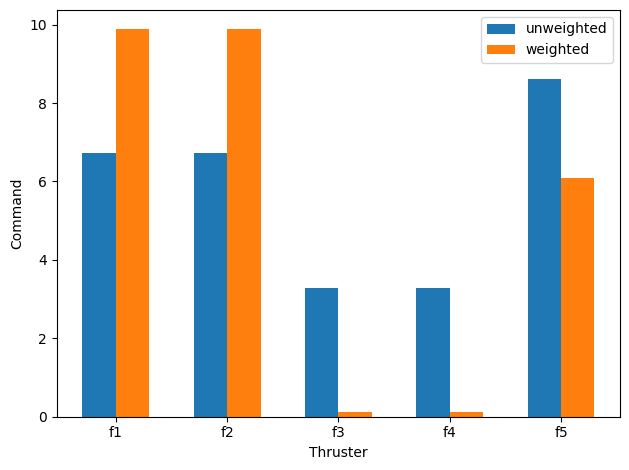

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Thruster configuration / allocation matrix (3x5)
B = np.array([[1.0, 0.0, 1.0, 0.0, 0.0],
              [0.0, 1.0, 0.0, 1.0, 0.0],
              [0.2, 0.2,-0.2,-0.2, 1.0]])

# Commanded generalized force/moment (3,)
tau_cmd = np.array([10.0, 10.0, 10.0])

# Weight matrix (5x5), SPD. Larger weight => more penalty on that thruster
W = np.diag([1.0, 1.0, 1.0, 1.0, 4.0])

W_inv_BT = np.linalg.solve(W, B.T)     # = W^{-1} B^T  (5x3)
M = B @ W_inv_BT                       # = B W^{-1} B^T (3x3)

# Robust inversion of M
rcond = 1e-12
cond_M = np.linalg.cond(M)
if not np.isfinite(cond_M) or cond_M > 1.0 / rcond:
    M_inv = np.linalg.pinv(M, rcond=rcond)
else:
    M_inv = np.linalg.inv(M)

B_W_dag = W_inv_BT @ M_inv             # (5x3)
f = B_W_dag @ tau_cmd                  # (5,)

tau_achieved = B @ f
residual = tau_cmd - tau_achieved

# ----- Compare with unweighted minimum-norm pseudoinverse -----
B_dag = np.linalg.pinv(B)
f_unw = B_dag @ tau_cmd
tau_unw = B @ f_unw

# ----- Simple visualization -----
idx = np.arange(1, 6)

plt.figure()
plt.bar(idx - 0.15, f_unw, width=0.3, label="unweighted")
plt.bar(idx + 0.15, f,     width=0.3, label="weighted")
plt.xticks(idx, [f"f{i}" for i in idx])
plt.xlabel("Thruster")
plt.ylabel("Command")
plt.legend()
plt.tight_layout()
plt.show()